# Assignment - 2
# Prakhar Jain
# 2022121008

Data preparation and rules
Please use the images of the MNIST hand-written digits recognition dataset. You may use torchvision.datasets
library to obtain the images and splits. You should have 60,000 training images and 10,000 test images. Use test
images only to evaluate your model performance.

## Q1: SIFT-BoVW-SVM [4 points]

1. [2 points] Implement the SIFT detector and descriptor. Compute cluster centers for the Bag-of-Visual-Words
approach. Represent the images as histograms (of visual words) and train a linear SVM model for 10-way
classification.

    `Note` 1: You may want to use libraries such as cv2 (OpenCV) and sklearn (Sci-kit learn) for doing this question.
https://scikit-learn.org/stable/modules/svm.html#multi-class-classification may be useful for the
SVM.

    `Note` 2: Seed random numbers for reproducibility (running the notebook again should give you the same results!).


---

In [1]:
DATASET_PATH = "MNIST"

DEBUG = False

In [2]:
import cv2
import numpy as np
from sklearn.cluster import KMeans #, MiniBatchKMeans
from sklearn import svm
# from sklearn.model_selection import train_test_split
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
class SIFT_SVM_Classifier:
    def __init__(self, dataset_path, n_clusters=8, sift_features=0, svm_c=1.0, svm_kernel='linear'):
        """
        Initialize the classifier with the dataset path, number of clusters for KMeans,
        number of SIFT features to extract, and SVM parameters.
        """
        self.dataset_path = dataset_path
        self.n_clusters = n_clusters
        self.sift_features = sift_features  # New SIFT parameter
        self.svm_c = svm_c  # New SVM parameter for regularization strength
        self.svm_kernel = svm_kernel  # New SVM parameter for kernel type
        self.kmeans = None
        self.clf = svm.SVC(kernel=self.svm_kernel, C=self.svm_c, decision_function_shape='ovr', random_state=42)
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor(),
        ])

    def load_data(self):
        """
        Load the MNIST dataset using torchvision's datasets module.
        Returns two DataLoader objects for the training and testing datasets.
        """
        torch.manual_seed(42)
        train_dataset = datasets.MNIST(self.dataset_path, train=True, download=True, transform=self.transform)
        test_dataset = datasets.MNIST(self.dataset_path, train=False, download=True, transform=self.transform)

        # print the no of images in the dataset
        # print('Number of images in dataset:', len(train_dataset))

        train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

        return train_dataloader, test_dataloader

    def extract_sift_features(self, image):
        """
        Use OpenCV's SIFT_create method to extract SIFT features from an image.
        """
        sift = cv2.SIFT_create(nfeatures=self.sift_features)
        keypoints, descriptors = sift.detectAndCompute(image, None)
        return descriptors

    def compute_kmeans(self, sift_features):
        """
        Compute the KMeans clustering on the SIFT features extracted from the images.
        """
        # self.kmeans = MiniBatchKMeans(n_clusters=self.n_clusters, random_state=42)
        self.kmeans = KMeans(n_clusters=self.n_clusters, n_init=10, random_state=42)
        self.kmeans.fit(np.concatenate(sift_features))

    def image_to_histogram(self, descriptors):
        """
        Convert the SIFT descriptors of an image into a histogram of visual words
        by assigning each descriptor to the closest cluster center.
        """
        histogram = np.zeros(self.n_clusters)
        if descriptors is not None:
            predicted_labels = self.kmeans.predict(descriptors)
            for label in predicted_labels:
                histogram[label] += 1
        return histogram

    def prepare_features(self, dataloader, isTrain=False):
        """
        Prepare the histograms and labels for all images in a DataLoader.
        """
        sift_features = []
        labels = []
        for images, label in dataloader:

            image = images.squeeze().numpy() * 255

            image = image.astype(np.uint8)

            descriptors = self.extract_sift_features(image)
            if descriptors is not None:
                sift_features.append(descriptors)
                labels.append(label.item())
        if isTrain:
            self.compute_kmeans(sift_features)

        histograms = [self.image_to_histogram(feat) for feat in sift_features]
        return histograms, labels

    def train(self, X_train, y_train):
        """
        Train the SVM classifier on the training data.
        """
        self.clf.fit(X_train, y_train)

    def test(self, X_test, y_test):
        """
        Test the SVM classifier on the testing data and return the accuracy score.
        """
        return self.clf.score(X_test, y_test)

    def run(self):
        """
        Orchestrates the entire process: load the data, prepare the features,
        train the classifier, test it, and print the accuracy.
        """
        train_dataloader, test_dataloader = self.load_data()

        X_train, y_train = self.prepare_features(train_dataloader, isTrain=True)

        X_test, y_test = self.prepare_features(test_dataloader)

        self.train(X_train, y_train)

        accuracy = self.test(X_test, y_test)

        # print('Accuracy:', accuracy)
        return accuracy


---

2. [1 point] Keeping everything else constant, plot how classification accuracy changes as you sweep across 6 different
values for the number of clusters. Please decide what numbers are meaningful for this question. Explain the
trends in classification accuracy that you observe.

    `Note` 1: It is recommended to try hyperparameters in logarithmic steps such as 2x or 3x multiples. An example
of 2x multiples is: 1, 2, 5, 10, 20, ... An example of 3x multiples is: 1, 3, 10, 30, 100, ...

Running with 5 clusters
Accuracy with 5 clusters: 0.3330269607843137
Running with 10 clusters
Accuracy with 10 clusters: 0.44873366013071897
Running with 20 clusters
Accuracy with 20 clusters: 0.5318627450980392
Running with 40 clusters
Accuracy with 40 clusters: 0.641748366013072
Running with 80 clusters
Accuracy with 80 clusters: 0.7316176470588235
Running with 160 clusters
Accuracy with 160 clusters: 0.795547385620915
Running with 320 clusters
Accuracy with 320 clusters: 0.8291462418300654


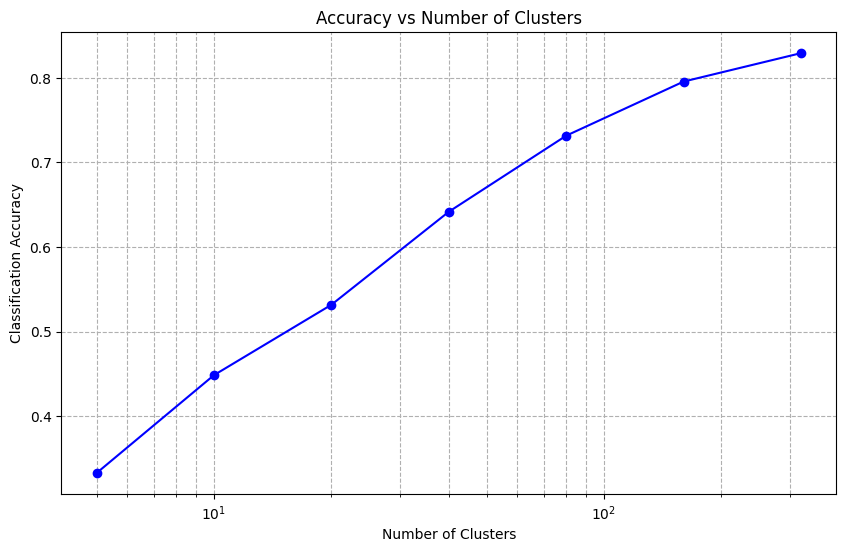

Best accuracy: (320, 0.8291462418300654)


In [3]:
def experiment_with_clusters(dataset_path):
    np.random.seed(0)
    n_clusters_options = [5, 10, 20, 40, 80, 160, 320]
    accuracies = []

    for n_clusters in n_clusters_options:
        print(f"Running with {n_clusters} clusters")
        classifier = SIFT_SVM_Classifier(dataset_path, n_clusters=n_clusters)
        accuracy = classifier.run()
        accuracies.append((n_clusters, accuracy))
        print(f"Accuracy with {n_clusters} clusters: {accuracy}")

    # Plotting the results
    plt.figure(figsize=(10, 6))
    clusters, accs = zip(*accuracies)
    plt.plot(clusters, accs, marker='o', linestyle='-', color='b')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Classification Accuracy')
    plt.title('Accuracy vs Number of Clusters')
    plt.xscale('log')
    plt.grid(True, which="both", ls="--")
    plt.show()

    return accuracies

accuracies = experiment_with_clusters(DATASET_PATH)

print("Best accuracy:", max(accuracies, key=lambda x: x[1]))

Increasing the `n_clusters` the accuracy increases as more clusters mean that the visual words in our Bag-of-Visual-Words (BoVW) model are more granular which leads to a more discriminative representation of the images. However, after a certain point, the accuracy starts to plateau as after a certain point additional clusters only capture noise that is not useful for classification.

---

3. [1 point] Show the results for 6 different hyperparameter settings. You may play with the SIFT detector or
descriptor and the linear SVM. Keep the number of clusters constant based on the answer to the previous
question. Explain the trends in classification accuracy that you observe.

Running with C=10.0, SIFT Features=10
Accuracy with C=10.0, SIFT Features=10: 0.7883986928104575
Running with C=10.0, SIFT Features=50
Accuracy with C=10.0, SIFT Features=50: 0.7981004901960784
Running with C=10.0, SIFT Features=100
Accuracy with C=10.0, SIFT Features=100: 0.797998366013072
Running with C=100.0, SIFT Features=10
Accuracy with C=100.0, SIFT Features=10: 0.7889093137254902
Running with C=100.0, SIFT Features=50
Accuracy with C=100.0, SIFT Features=50: 0.7973856209150327
Running with C=100.0, SIFT Features=100
Accuracy with C=100.0, SIFT Features=100: 0.7977941176470589


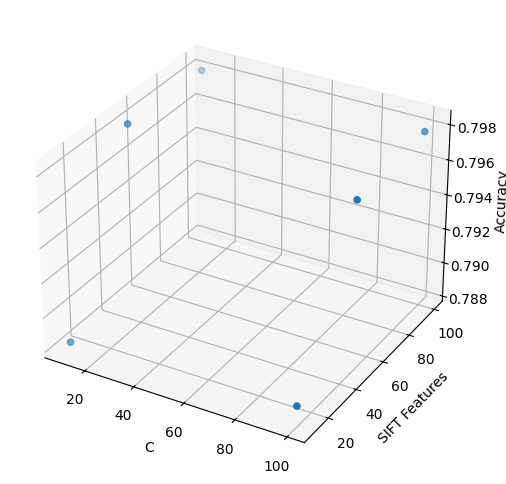

Best accuracy: (10.0, 50, 0.7981004901960784)


In [5]:
def experiment_with_hyperparameters(dataset_path):

    np.random.seed(0)

    n_clusters = 160

    accuracies = []

    for c in [10.0, 100.0]:
        for sift_features in [10, 50, 100]:
            print(f"Running with C={c}, SIFT Features={sift_features}")
            classifier = SIFT_SVM_Classifier(dataset_path, n_clusters=n_clusters, sift_features=sift_features, svm_c=c)
            accuracy = classifier.run()
            accuracies.append((c, sift_features, accuracy))
            print(f"Accuracy with C={c}, SIFT Features={sift_features}: {accuracy}")


    # Do a 3D plot of the results
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    cs, ss, accs = zip(*accuracies)
    ax.scatter(cs, ss, accs)
    ax.set_xlabel('C')
    ax.set_ylabel('SIFT Features')
    ax.set_zlabel('Accuracy')
    plt.show()

    return accuracies

accuracies = experiment_with_hyperparameters(DATASET_PATH)

print("Best accuracy:", max(accuracies, key=lambda x: x[2]))

It seems only `sift_features` affects the accuracy and not `C` in SVM.

---